# Clustering for gevtev

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.neighbors import DistanceMetric
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import cluster
from sklearn.decomposition.pca import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn import preprocessing

In [2]:
#path_to_gamma_bins shoud contain an absolute path to your gamma-bins directory
path_to_gamma_bins = os.path.dirname(os.getcwd()) + "/"

In [3]:
#name columns included in the final display
other_names = ['gev_1FGL_Name', 'gev_CLASS1', 'tev_fermi_names', 'tev_classes', 'marked', 's_class', 's_MAIN_ID', 's_simbad']
#from gamma bins directory
path_to_catalog = "markeddata/gevtev_simbadclasses_TeVspectrum_normalized.txt"

In [4]:
spectra = pd.read_csv(path_to_gamma_bins +path_to_catalog)
spectra.head()

,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV,s_class,s_MAIN_ID,s_simbad,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,0.055155,0.201477,0.000004,0.235066,0.028249,0.0,0.391619,0.072841,0.013193,0.002028,0.000367,[],[],0,b' ',b'bll ',b'',b'hbl',0
1,0.069119,0.073172,0.003407,0.038325,0.145615,0.0,0.134071,0.020429,0.006452,0.059379,0.450031,[],[],0,b' ',b'snr ',b'',b'snr',0
2,0.358190,0.178179,0.096737,0.268908,0.097987,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,[],[],0,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',0
3,0.269005,0.157462,0.139724,0.220561,0.213247,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,[],[],0,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',0
4,0.427725,0.147237,0.104148,0.231066,0.089825,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,[],[],0,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',0


In [5]:
spectrum_columns = spectra.columns[:-len(other_names)]

In [6]:
def get_distance_metric(metric_function):
    if type(metric_function) == str:
        dist = DistanceMetric.get_metric(metric_function)
    else:
        dist = DistanceMetric.get_metric("pyfunc", func=metric_function)
    return dist

In [7]:
def build_images(spectra_distances, TSNE_learning_rate=500, TSNE_n_iter=1500, TSNE_learning_rate2=300):
    colors = ['red','black']
    c = spectra['marked'].apply(lambda x: colors[x])
    
    x = spectra[spectrum_columns].values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    
    x_distances = spectra_distances #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_distances_scaled = min_max_scaler.fit_transform(x_distances)

    plt.subplots(figsize=(18, 6))
    plt.subplot(131)
    plt.title("PCA")
    pca = PCA(n_components=2, random_state=42)
    spectra_2D = pca.fit_transform(x_scaled)
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

    plt.subplot(132)
    plt.title("TSNE, Euclidean distance")
    tsne = TSNE(n_components=2, random_state=42, learning_rate=TSNE_learning_rate, n_iter=TSNE_n_iter)
    spectra_2D = tsne.fit_transform(x_scaled)
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

    plt.subplot(133)
    plt.title("TSNE, Chosen distance")
    tsne = TSNE(n_components=2, random_state=42, metric="precomputed", learning_rate=TSNE_learning_rate2)
    spectra_2D = tsne.fit_transform(x_distances_scaled)
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)
    plt.show()
    
    
    # visualization - tsne with chosen distance
    print('Clustering')
    plt.subplots(figsize=(18, 12))
    plt.subplot(3, 3, 1)

    colors = ['red','black']
    c = spectra['marked'].apply(lambda x: colors[x])
    plt.title("true labels")
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
              'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

    for n in range(2, 10):
        kmeans = cluster.KMeans(n_clusters=n, random_state=42)
        cluster_labels = kmeans.fit_predict(spectra_distances)

        plt.subplot(3, 3, n)
        c = [colors[l] for l in cluster_labels]
        plt.title("cluster labels ({} clusters)".format(n))
        plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

    plt.show()
    
def print_clusters_structure(spectra_distances, n):
    kmeans = cluster.KMeans(n_clusters=n, random_state=42)
    cluster_labels = kmeans.fit_predict(spectra_distances)
    centers = []

    spectra['KMeans_clusters_' + str(n)] = cluster_labels
    for i in range(n):
        print("{} cluster".format(i))
        display(spectra[spectra['KMeans_clusters_' + str(n)] == i][other_names])
        centers.append(spectra.loc[spectra['KMeans_clusters_' + str(n)] == i, spectrum_columns].mean(axis=0).values)
    centers = pd.DataFrame(np.column_stack(centers).T, columns=spectrum_columns)
    del spectra['KMeans_clusters_' + str(n)]

    # centroids
    print("centroids:")
    display(centers)
    # plt.figure(figsize=(20, 10))
    # sns.heatmap(centers, vmin=0, vmax=1)
    # plt.show()

* ### earth mover's distance

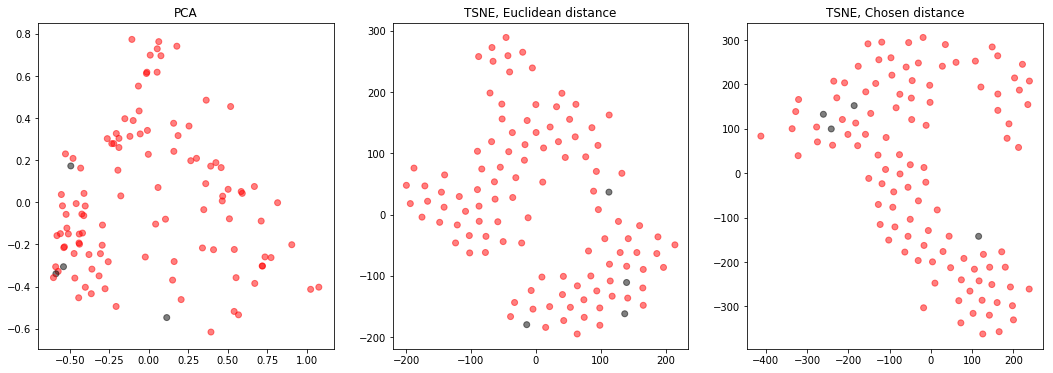

Clustering


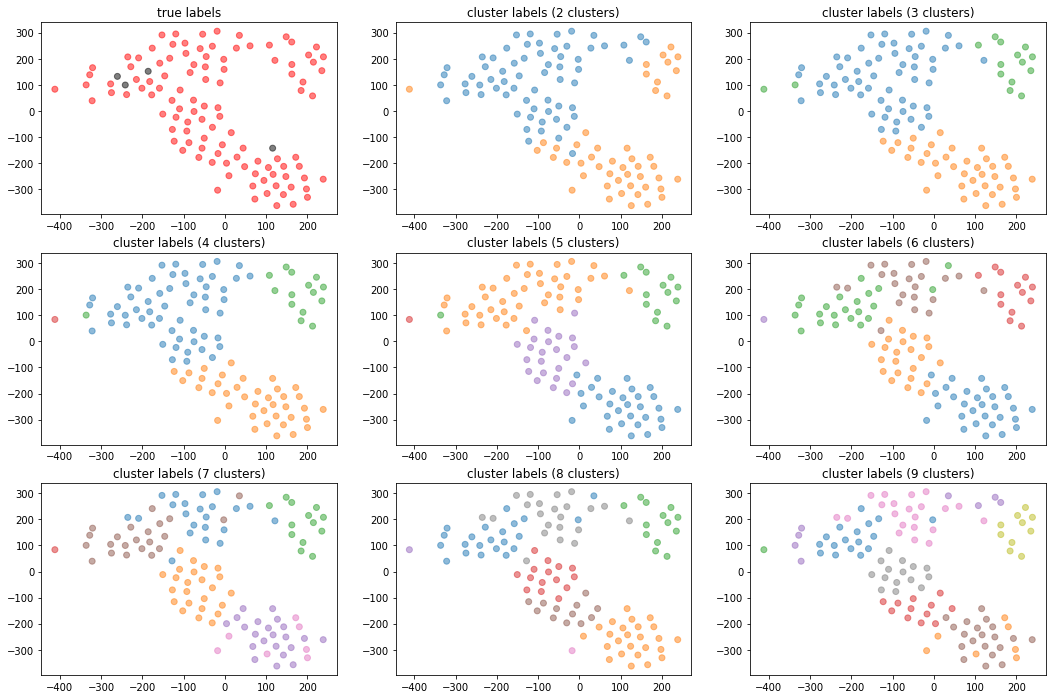

0 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
5,b' ',b'bll ',b'',b'hbl',0,[],[],0
20,b'1FGL J0521.7+2114 ',b'bll ',b'',b'ibl',0,[],[],0
24,b' ',b'PWN ',b'',b'pwn',0,[],[],0
30,b'1FGL J0710.6+5911 ',b'bll ',b'1FGL J0710.6+5911',b'hbl',0,[],[],0
31,b'1FGL J0721.9+7120 ',b'BLL ',b'',b'ibl',0,[],[],0
33,b' ',b'PWN ',b'',b'pwn',0,[],[],0
37,b' ',b'bll ',b'',b'hbl',0,[],[],0
43,b'1FGL J1104.4+3812 ',b'BLL ',b'',b'hbl',0,[],[],0
45,b'1FGL J1136.6+7009 ',b'bll ',b'',b'hbl',0,[],[],0
54,b' ',b'PWN ',b'',b'pwn',0,[],[],0


1 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
3,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',0,[],[],0
8,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'ibl',0,[],[],0
9,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'unid',0,[],[],0
12,b'1FGL J0303.5-2406 ',b'BLL ',b'',b'hbl',0,[],[],0
14,b'1FGL J0319.7+4130 ',b'RDG ',b'',b'fri',0,[],[],0
18,b'1FGL J0449.5-4350 ',b'bll ',b'',b'hbl',0,[],[],0
25,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'pwn',0,[],[],0
28,b'1FGL J0648.8+1516 ',b'bll ',b'1FGL J0648.8+1516',b'hbl',0,[],[],0
32,b'1FGL J0809.5+5219 ',b'bll ',b'',b'hbl',0,[],[],0
35,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0,['B0Ve'],"[""b'[CHP2004] J095549.8+693934'"" ""b'[MTK2001b]...",2


2 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
6,b'1FGL J0205.6+6449 ',b'PSR ',b'',b'pwn',0,[],[],0
11,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1,['B0Ve'],"[""b'LS I +61 303'"" ""b'LS I +61 303'""]",1
13,b' ',b'rdg ',b'',b'hbl',0,[],[],0
23,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'psr',0,[],[],0
26,b' ',b'bll ',b'',b'hbl',0,[],[],0
27,b'1FGL J0633.9+1746 ',b'PSR ',b'',"b'psr,pwn'",0,[],[],0
34,b'1FGL J0847.2+1134 ',b'bll ',"b'1FGL J0847.2+113,2FGL J0847.2+1134,3FGL J084...",b'hbl',0,[],[],0
39,b' ',b'PSR ',b'',b'pwn',0,[],[],0
40,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1,['B0Ve'],"[""b'2FGL J1019.0-5856'""]",2
41,b'1FGL J1028.4-5819 ',b'PSR ',b'',b'pwn',0,[],[],0


3 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
1,b' ',b'snr ',b'',b'snr',0,[],[],0
10,b' ',b'bll ',b'',b'hbl',0,[],[],0
16,b' ',b'bll ',b'',b'hbl',0,[],[],0
19,b'1FGL J0507.9+6738 ',b'bll ',b'',b'hbl',0,[],[],0
21,b' ',b' ',b'',"b'snr,mc'",0,[],[],0
38,b'1FGL J1015.1+4927 ',b'bll ',b'',b'hbl',0,[],[],0
42,b'1FGL J1103.7-2329 ',b'bll ',b'',b'hbl',0,[],[],0
49,b'1FGL J1221.5+2814 ',b'bll ',b'',b'ibl',0,[],[],0
56,b'1FGL J1325.6-4300 ',b'RDG ',b'',b'fri',0,[],[],0
57,b' ',b'PSR ',b'',b'pwn',0,[],[],0


4 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
65,b'1FGL J1512.8-0906 ',b'FSRQ ',b'',b'fsrq',0,[],[],0


5 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
0,b' ',b'bll ',b'',b'hbl',0,[],[],0
2,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',0,[],[],0
4,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',0,[],[],0
7,b'1FGL J0221.0+3555 ',b'FSRQ ',b'',b'blazar',0,[],[],0
15,b'1FGL J0319.7+1847 ',b'bll ',b'',b'hbl',0,[],[],0
17,b'1FGL J0416.8+0107 ',b'bll ',b'',b'hbl',0,[],[],0
22,b' ',b'PWN ',b'',b'psr',0,[],[],0
29,b'1FGL J0650.7+2503 ',b'bll ',b'',b'hbl',0,[],[],0
36,b'1FGL J1000.1+6539 ',b'bll ',b'',b'blazar',0,[],[],0
51,b'1FGL J1224.7+2121 ',b'FSRQ ',b'',b'fsrq',0,[],[],0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.157887,0.115108,0.116243,0.123824,0.104277,0.0,0.148215,0.086306,0.061824,0.046267,0.040049
1,0.169654,0.204310,0.180719,0.208492,0.187727,0.0,0.037446,0.006956,0.003255,0.001017,0.000423
2,0.078475,0.283742,0.190158,0.174768,0.263846,0.0,0.003960,0.001690,0.001446,0.001023,0.000893
3,0.130234,0.064370,0.149414,0.066984,0.105770,0.0,0.152338,0.036202,0.029802,0.057539,0.207346
4,0.000057,0.000393,0.000838,0.000202,0.000636,0.0,0.000009,0.000187,0.002927,0.059691,0.935061
5,0.139185,0.178832,0.210131,0.149118,0.198320,0.0,0.085043,0.020367,0.009205,0.006785,0.003013


In [8]:
# earth mover's distance
metric_function = st.wasserstein_distance
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
# spectra_distances = get_distance_metric(metric_function).pairwise(spectra[spectrum_columns])
#pd.DataFrame(spectra_distances).to_csv(path_to_gamma_bins +"markeddata/gevtev_spectra_EM_distances.txt", index=False)
build_images(spectra_distances, 700, 1500, 800)
print_clusters_structure(spectra_distances, 6)

* ### euclidean distance

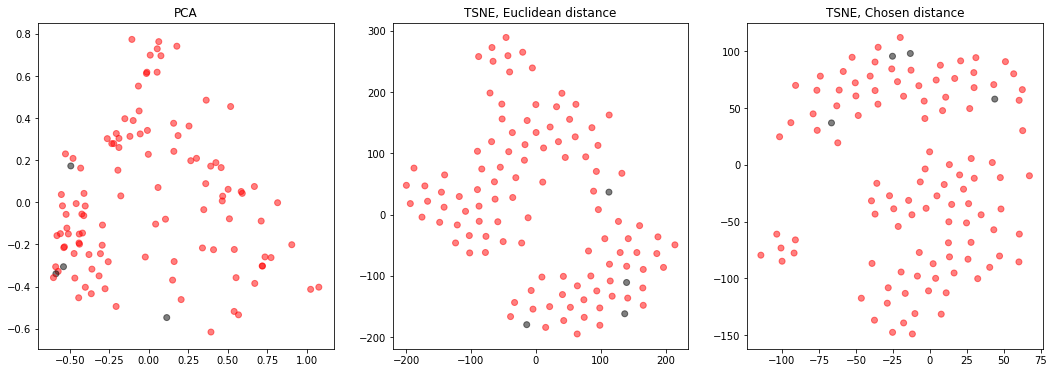

Clustering


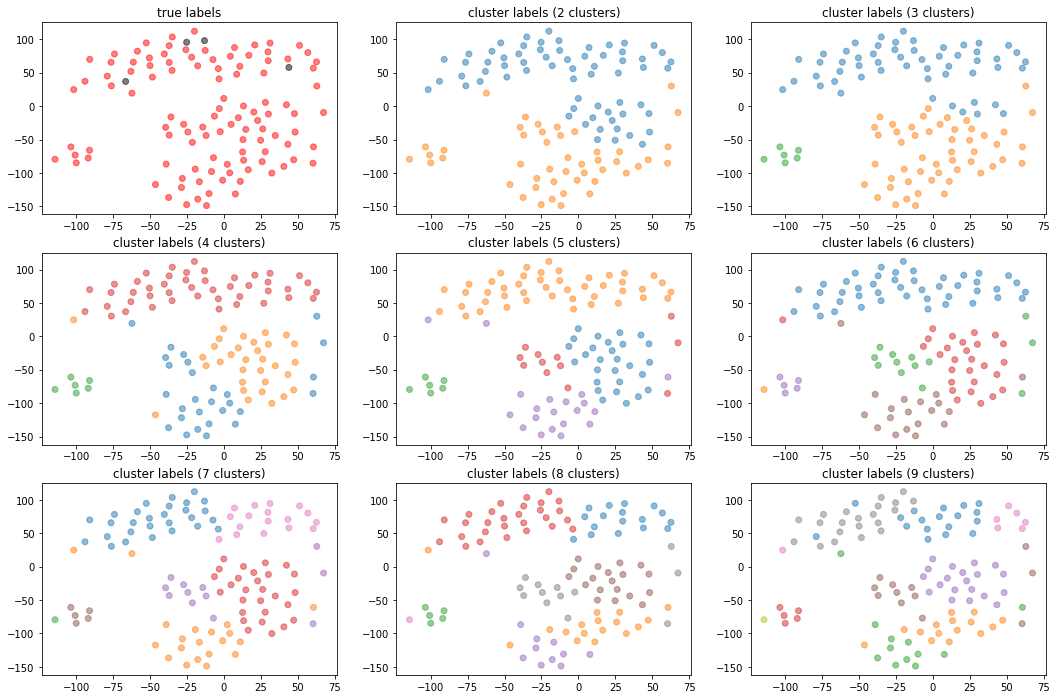

0 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
6,b'1FGL J0205.6+6449 ',b'PSR ',b'',b'pwn',0,[],[],0
7,b'1FGL J0221.0+3555 ',b'FSRQ ',b'',b'blazar',0,[],[],0
11,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1,['B0Ve'],"[""b'LS I +61 303'"" ""b'LS I +61 303'""]",1
14,b'1FGL J0319.7+4130 ',b'RDG ',b'',b'fri',0,[],[],0
23,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'psr',0,[],[],0
25,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'pwn',0,[],[],0
27,b'1FGL J0633.9+1746 ',b'PSR ',b'',"b'psr,pwn'",0,[],[],0
33,b' ',b'PWN ',b'',b'pwn',0,[],[],0
35,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0,['B0Ve'],"[""b'[CHP2004] J095549.8+693934'"" ""b'[MTK2001b]...",2
36,b'1FGL J1000.1+6539 ',b'bll ',b'',b'blazar',0,[],[],0


1 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
65,b'1FGL J1512.8-0906 ',b'FSRQ ',b'',b'fsrq',0,[],[],0


2 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
2,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',0,[],[],0
4,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',0,[],[],0
13,b' ',b'rdg ',b'',b'hbl',0,[],[],0
15,b'1FGL J0319.7+1847 ',b'bll ',b'',b'hbl',0,[],[],0
19,b'1FGL J0507.9+6738 ',b'bll ',b'',b'hbl',0,[],[],0
21,b' ',b' ',b'',"b'snr,mc'",0,[],[],0
22,b' ',b'PWN ',b'',b'psr',0,[],[],0
26,b' ',b'bll ',b'',b'hbl',0,[],[],0
29,b'1FGL J0650.7+2503 ',b'bll ',b'',b'hbl',0,[],[],0
34,b'1FGL J0847.2+1134 ',b'bll ',"b'1FGL J0847.2+113,2FGL J0847.2+1134,3FGL J084...",b'hbl',0,[],[],0


3 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
3,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',0,[],[],0
8,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'ibl',0,[],[],0
9,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'unid',0,[],[],0
12,b'1FGL J0303.5-2406 ',b'BLL ',b'',b'hbl',0,[],[],0
18,b'1FGL J0449.5-4350 ',b'bll ',b'',b'hbl',0,[],[],0
20,b'1FGL J0521.7+2114 ',b'bll ',b'',b'ibl',0,[],[],0
31,b'1FGL J0721.9+7120 ',b'BLL ',b'',b'ibl',0,[],[],0
32,b'1FGL J0809.5+5219 ',b'bll ',b'',b'hbl',0,[],[],0
43,b'1FGL J1104.4+3812 ',b'BLL ',b'',b'hbl',0,[],[],0
46,b'1FGL J1136.2+6739 ',b'bll ',b'',b'hbl',0,[],[],0


4 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
1,b' ',b'snr ',b'',b'snr',0,[],[],0
16,b' ',b'bll ',b'',b'hbl',0,[],[],0
38,b'1FGL J1015.1+4927 ',b'bll ',b'',b'hbl',0,[],[],0
42,b'1FGL J1103.7-2329 ',b'bll ',b'',b'hbl',0,[],[],0
69,b'1FGL J1555.7+1111 ',b'BLL ',b'',b'hbl',0,[],[],0


5 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
0,b' ',b'bll ',b'',b'hbl',0,[],[],0
5,b' ',b'bll ',b'',b'hbl',0,[],[],0
10,b' ',b'bll ',b'',b'hbl',0,[],[],0
17,b'1FGL J0416.8+0107 ',b'bll ',b'',b'hbl',0,[],[],0
24,b' ',b'PWN ',b'',b'pwn',0,[],[],0
28,b'1FGL J0648.8+1516 ',b'bll ',b'1FGL J0648.8+1516',b'hbl',0,[],[],0
30,b'1FGL J0710.6+5911 ',b'bll ',b'1FGL J0710.6+5911',b'hbl',0,[],[],0
37,b' ',b'bll ',b'',b'hbl',0,[],[],0
45,b'1FGL J1136.6+7009 ',b'bll ',b'',b'hbl',0,[],[],0
49,b'1FGL J1221.5+2814 ',b'bll ',b'',b'ibl',0,[],[],0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.032026,0.234135,0.268899,0.127643,0.273874,0.0,0.023778,0.014571,0.010618,0.008727,0.005731
1,0.000057,0.000393,0.000838,0.000202,0.000636,0.0,0.000009,0.000187,0.002927,0.059691,0.935061
2,0.399042,0.164704,0.047170,0.236372,0.081918,0.0,0.022925,0.013262,0.014637,0.012300,0.007671
3,0.204113,0.168191,0.132884,0.201579,0.135431,0.0,0.076896,0.033963,0.020694,0.012426,0.013823
4,0.078004,0.041391,0.011833,0.049710,0.049516,0.0,0.080082,0.021528,0.027623,0.120868,0.519444
5,0.125595,0.082752,0.099948,0.094567,0.082094,0.0,0.280246,0.095703,0.061352,0.043491,0.034252


In [9]:
# euclidean distance
from scipy.spatial.distance import euclidean
metric_function = "euclidean"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances, 700, 1500, 400)
print_clusters_structure(spectra_distances, 6)

* ### cosine distance

$$ d(u, v) = 1 -  \frac{uv}{||u||_{2}||v||_{2}}$$

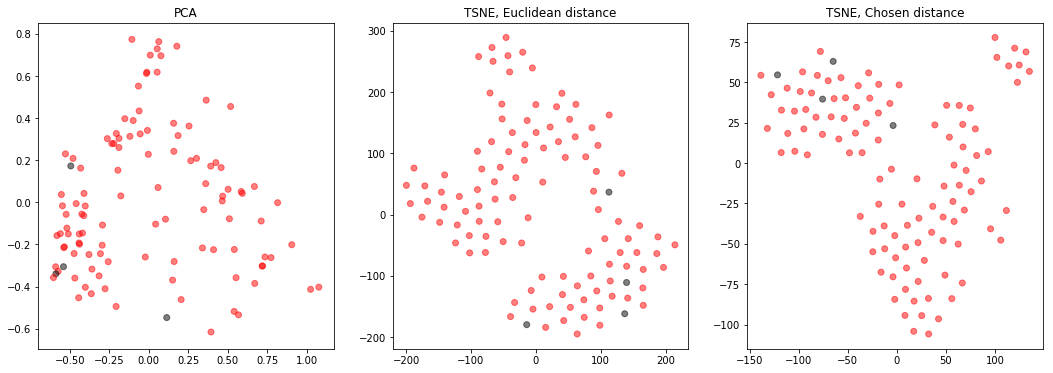

Clustering


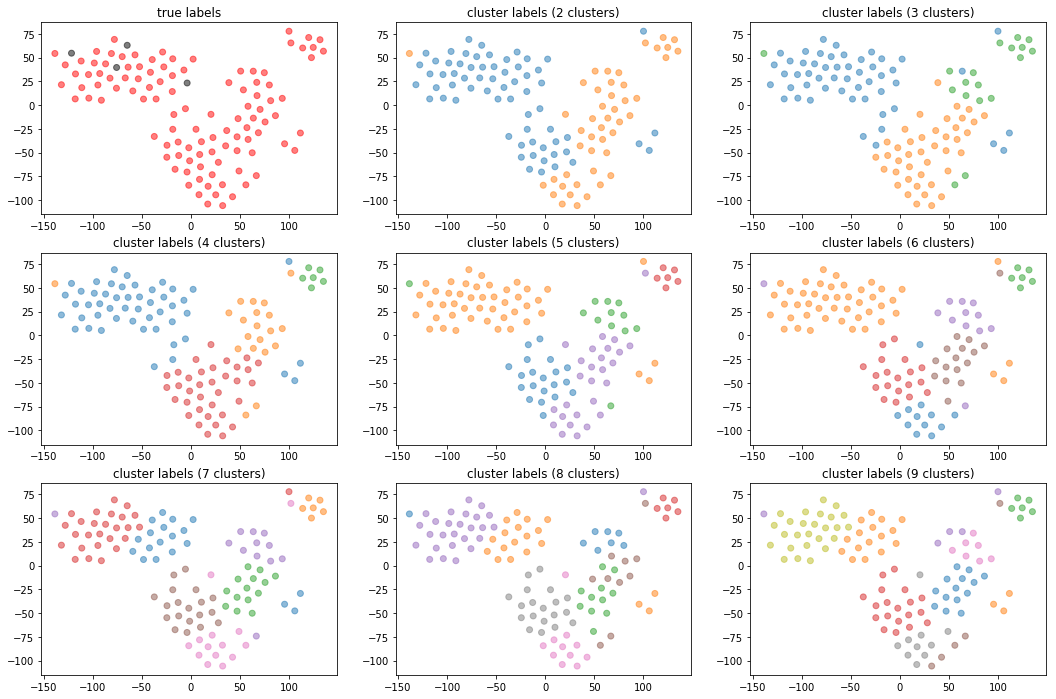

0 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
14,b'1FGL J0319.7+4130 ',b'RDG ',b'',b'fri',0,[],[],0
27,b'1FGL J0633.9+1746 ',b'PSR ',b'',"b'psr,pwn'",0,[],[],0
35,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0,['B0Ve'],"[""b'[CHP2004] J095549.8+693934'"" ""b'[MTK2001b]...",2
41,b'1FGL J1028.4-5819 ',b'PSR ',b'',b'pwn',0,[],[],0
52,b'1FGL J1230.8+1223 ',b'rdg ',b'',b'fri',0,[],[],0
58,b'1FGL J1418.7-6057 ',b'PSR ',b'',b'pwn',0,[],[],0
59,b'1FGL J1418.7-6057 ',b'PSR ',b'',b'pwn',0,[],[],0
76,b'1FGL J1714.5-3830c',b'snr ',b'',"b'snr,mc'",0,[],[],0
78,b'1FGL J1718.2-3825 ',b'PSR ',b'',b'pwn',0,[],[],0
83,b' ',b' ',b'',b'unid',0,['Be' 'B' 'B' 'O'],"[""b'SSTGC 519103'"" ""b'SSTGC 519103'"" ""b'GCIRS ...",1


1 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
1,b' ',b'snr ',b'',b'snr',0,[],[],0
16,b' ',b'bll ',b'',b'hbl',0,[],[],0
38,b'1FGL J1015.1+4927 ',b'bll ',b'',b'hbl',0,[],[],0
42,b'1FGL J1103.7-2329 ',b'bll ',b'',b'hbl',0,[],[],0
65,b'1FGL J1512.8-0906 ',b'FSRQ ',b'',b'fsrq',0,[],[],0
69,b'1FGL J1555.7+1111 ',b'BLL ',b'',b'hbl',0,[],[],0


2 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
5,b' ',b'bll ',b'',b'hbl',0,[],[],0
15,b'1FGL J0319.7+1847 ',b'bll ',b'',b'hbl',0,[],[],0
17,b'1FGL J0416.8+0107 ',b'bll ',b'',b'hbl',0,[],[],0
24,b' ',b'PWN ',b'',b'pwn',0,[],[],0
28,b'1FGL J0648.8+1516 ',b'bll ',b'1FGL J0648.8+1516',b'hbl',0,[],[],0
30,b'1FGL J0710.6+5911 ',b'bll ',b'1FGL J0710.6+5911',b'hbl',0,[],[],0
43,b'1FGL J1104.4+3812 ',b'BLL ',b'',b'hbl',0,[],[],0
45,b'1FGL J1136.6+7009 ',b'bll ',b'',b'hbl',0,[],[],0
72,b'1FGL J1640.8-4634c',b'spp ',b'',b'pwn',0,[],[],0
81,b'1FGL J1744.2+1934 ',b'bll ',b'',b'hbl',0,[],[],0


3 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
6,b'1FGL J0205.6+6449 ',b'PSR ',b'',b'pwn',0,[],[],0
7,b'1FGL J0221.0+3555 ',b'FSRQ ',b'',b'blazar',0,[],[],0
11,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1,['B0Ve'],"[""b'LS I +61 303'"" ""b'LS I +61 303'""]",1
23,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'psr',0,[],[],0
25,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'pwn',0,[],[],0
33,b' ',b'PWN ',b'',b'pwn',0,[],[],0
36,b'1FGL J1000.1+6539 ',b'bll ',b'',b'blazar',0,[],[],0
39,b' ',b'PSR ',b'',b'pwn',0,[],[],0
40,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1,['B0Ve'],"[""b'2FGL J1019.0-5856'""]",2
44,b'1FGL J1119.4-6127c',b'PSR ',b'',b'pwn',0,[],[],0


4 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
0,b' ',b'bll ',b'',b'hbl',0,[],[],0
10,b' ',b'bll ',b'',b'hbl',0,[],[],0
49,b'1FGL J1221.5+2814 ',b'bll ',b'',b'ibl',0,[],[],0
54,b' ',b'PWN ',b'',b'pwn',0,[],[],0
57,b' ',b'PSR ',b'',b'pwn',0,[],[],0
63,b'1FGL J1443.8+2457 ',b'fsrq ',b'3FGL J1443.9+2502',b'fsrq',0,[],[],0
66,b'1FGL J1513.2-5904 ',b'PSR ',b'',b'pwn',0,[],[],0
67,b'1FGL J1514.7-5917 ',b'PWN ',b'',b'pwn',0,[],[],0
71,b'1FGL J1626.0-4917c',b' ',b'',b'unid',0,[],[],0
75,b'1FGL J1711.7-3944c',b'SNR ',b'',b'snr',0,[],[],0


5 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
3,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',0,[],[],0
8,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'ibl',0,[],[],0
9,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'unid',0,[],[],0
12,b'1FGL J0303.5-2406 ',b'BLL ',b'',b'hbl',0,[],[],0
18,b'1FGL J0449.5-4350 ',b'bll ',b'',b'hbl',0,[],[],0
20,b'1FGL J0521.7+2114 ',b'bll ',b'',b'ibl',0,[],[],0
31,b'1FGL J0721.9+7120 ',b'BLL ',b'',b'ibl',0,[],[],0
32,b'1FGL J0809.5+5219 ',b'bll ',b'',b'hbl',0,[],[],0
46,b'1FGL J1136.2+6739 ',b'bll ',b'',b'hbl',0,[],[],0
47,b'1FGL J1217.7+3007 ',b'bll ',b'',b'hbl',0,[],[],0


6 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
2,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',0,[],[],0
4,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',0,[],[],0
13,b' ',b'rdg ',b'',b'hbl',0,[],[],0
19,b'1FGL J0507.9+6738 ',b'bll ',b'',b'hbl',0,[],[],0
21,b' ',b' ',b'',"b'snr,mc'",0,[],[],0
22,b' ',b'PWN ',b'',b'psr',0,[],[],0
26,b' ',b'bll ',b'',b'hbl',0,[],[],0
29,b'1FGL J0650.7+2503 ',b'bll ',b'',b'hbl',0,[],[],0
34,b'1FGL J0847.2+1134 ',b'bll ',"b'1FGL J0847.2+113,2FGL J0847.2+1134,3FGL J084...",b'hbl',0,[],[],0
37,b' ',b'bll ',b'',b'hbl',0,[],[],0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.035722,0.306657,0.160522,0.176208,0.289881,0.0,0.012649,0.006399,0.005212,0.005200,0.001551
1,0.065013,0.034558,0.010000,0.041459,0.041369,0.0,0.066737,0.017971,0.023507,0.110672,0.588713
2,0.222731,0.131923,0.042277,0.163071,0.084460,0.0,0.213176,0.078976,0.037185,0.016394,0.009808
3,0.030399,0.179411,0.342065,0.093458,0.257385,0.0,0.031821,0.019966,0.014365,0.012848,0.018283
4,0.068197,0.074148,0.122118,0.075636,0.090565,0.0,0.301242,0.111958,0.078870,0.051441,0.025824
5,0.211460,0.177559,0.166865,0.211891,0.151963,0.0,0.051864,0.012962,0.007328,0.005065,0.003042
6,0.376884,0.155570,0.058572,0.226419,0.080532,0.0,0.011534,0.017238,0.022862,0.024151,0.026239


In [10]:
# cosine distance
# from scipy.spatial.distance import cosine
metric_function = "cosine"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances, 700, 1500, 400)
print_clusters_structure(spectra_distances, 7)

* ### energy distance

The energy distance between two distributions $u$ and $v$ , whose respective CDFs are $U$ and $V$, equals to: 
$$D(u, v) = (2\mathbb{E}|X-Y| - {E}|X-X'| - {E}|Y-Y'|)^{\frac{1}{2}}$$
where $X$ and $Y$ (resp. $X'$  and $Y'$ ) are independent random variables whose probability distribution is  (resp. ).

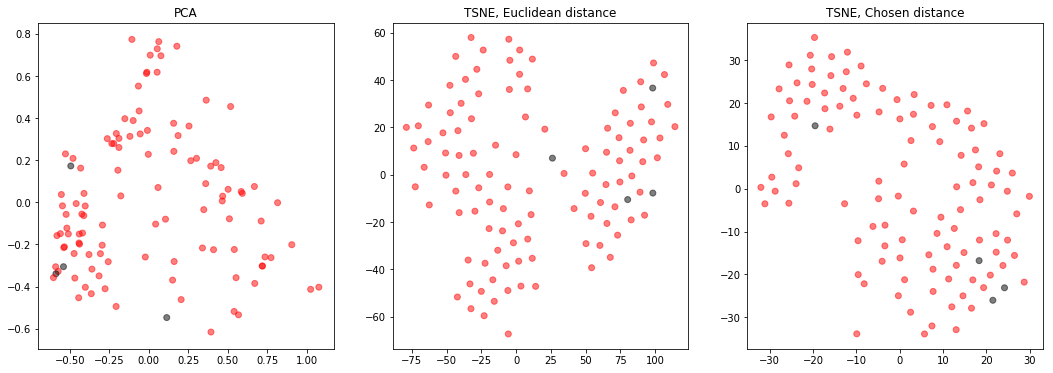

Clustering


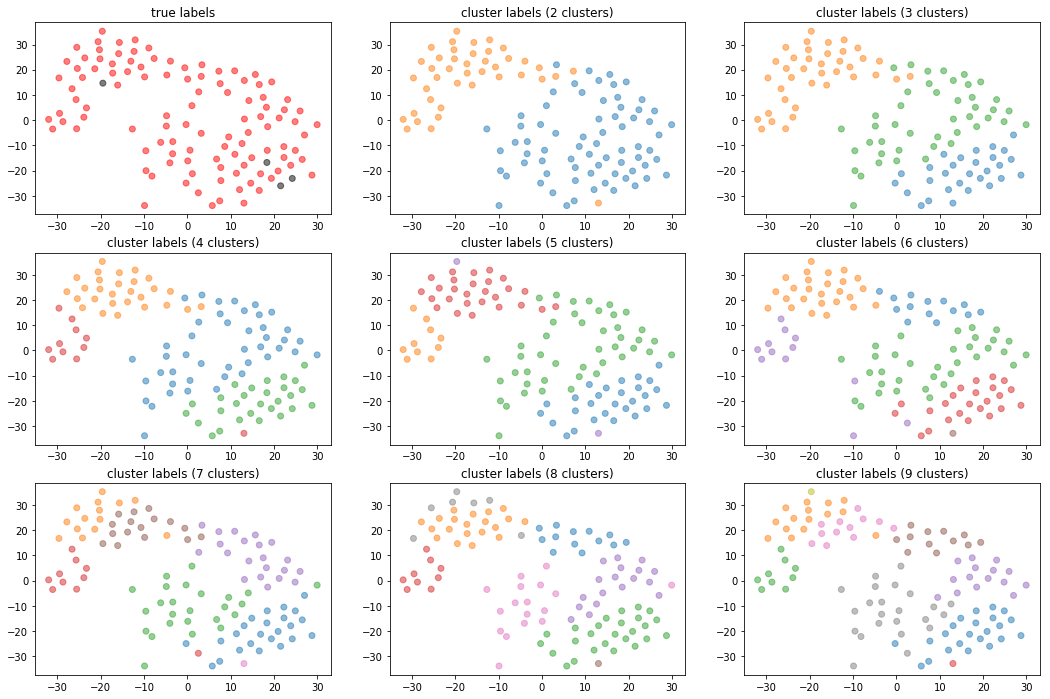

0 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
6,b'1FGL J0205.6+6449 ',b'PSR ',b'',b'pwn',0,[],[],0
11,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1,['B0Ve'],"[""b'LS I +61 303'"" ""b'LS I +61 303'""]",1
13,b' ',b'rdg ',b'',b'hbl',0,[],[],0
19,b'1FGL J0507.9+6738 ',b'bll ',b'',b'hbl',0,[],[],0
22,b' ',b'PWN ',b'',b'psr',0,[],[],0
23,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'psr',0,[],[],0
26,b' ',b'bll ',b'',b'hbl',0,[],[],0
27,b'1FGL J0633.9+1746 ',b'PSR ',b'',"b'psr,pwn'",0,[],[],0
34,b'1FGL J0847.2+1134 ',b'bll ',"b'1FGL J0847.2+113,2FGL J0847.2+1134,3FGL J084...",b'hbl',0,[],[],0
36,b'1FGL J1000.1+6539 ',b'bll ',b'',b'blazar',0,[],[],0


1 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
1,b' ',b'snr ',b'',b'snr',0,[],[],0
10,b' ',b'bll ',b'',b'hbl',0,[],[],0
16,b' ',b'bll ',b'',b'hbl',0,[],[],0
21,b' ',b' ',b'',"b'snr,mc'",0,[],[],0
38,b'1FGL J1015.1+4927 ',b'bll ',b'',b'hbl',0,[],[],0
42,b'1FGL J1103.7-2329 ',b'bll ',b'',b'hbl',0,[],[],0
49,b'1FGL J1221.5+2814 ',b'bll ',b'',b'ibl',0,[],[],0
57,b' ',b'PSR ',b'',b'pwn',0,[],[],0
66,b'1FGL J1513.2-5904 ',b'PSR ',b'',b'pwn',0,[],[],0
69,b'1FGL J1555.7+1111 ',b'BLL ',b'',b'hbl',0,[],[],0


2 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
0,b' ',b'bll ',b'',b'hbl',0,[],[],0
2,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',0,[],[],0
3,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',0,[],[],0
4,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',0,[],[],0
7,b'1FGL J0221.0+3555 ',b'FSRQ ',b'',b'blazar',0,[],[],0
8,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'ibl',0,[],[],0
9,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'unid',0,[],[],0
12,b'1FGL J0303.5-2406 ',b'BLL ',b'',b'hbl',0,[],[],0
14,b'1FGL J0319.7+4130 ',b'RDG ',b'',b'fri',0,[],[],0
15,b'1FGL J0319.7+1847 ',b'bll ',b'',b'hbl',0,[],[],0


3 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
5,b' ',b'bll ',b'',b'hbl',0,[],[],0
20,b'1FGL J0521.7+2114 ',b'bll ',b'',b'ibl',0,[],[],0
24,b' ',b'PWN ',b'',b'pwn',0,[],[],0
30,b'1FGL J0710.6+5911 ',b'bll ',b'1FGL J0710.6+5911',b'hbl',0,[],[],0
33,b' ',b'PWN ',b'',b'pwn',0,[],[],0
37,b' ',b'bll ',b'',b'hbl',0,[],[],0
43,b'1FGL J1104.4+3812 ',b'BLL ',b'',b'hbl',0,[],[],0
45,b'1FGL J1136.6+7009 ',b'bll ',b'',b'hbl',0,[],[],0
54,b' ',b'PWN ',b'',b'pwn',0,[],[],0
55,b' ',b'bcu ',b'',b'hbl',0,[],[],0


4 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
63,b'1FGL J1443.8+2457 ',b'fsrq ',b'3FGL J1443.9+2502',b'fsrq',0,[],[],0
65,b'1FGL J1512.8-0906 ',b'FSRQ ',b'',b'fsrq',0,[],[],0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.102904,0.252913,0.214384,0.168604,0.251300,0.0,0.003604,0.002165,0.001597,0.001387,0.001143
1,0.105247,0.056025,0.084668,0.052154,0.077468,0.0,0.197840,0.046117,0.038146,0.073618,0.268717
2,0.154746,0.191271,0.189231,0.180177,0.189818,0.0,0.068442,0.014268,0.006515,0.003885,0.001647
3,0.160702,0.112311,0.114436,0.119376,0.100277,0.0,0.148497,0.090151,0.064292,0.048146,0.041812
4,0.019355,0.038043,0.064034,0.056557,0.059390,0.0,0.072998,0.060791,0.052758,0.072499,0.503576


In [11]:
# energy distance
metric_function = st.energy_distance
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances)
print_clusters_structure(spectra_distances, 5)

- ### mahalanobis
$$d(u, v) = \sqrt{(u-v)V^{-1}(u+v)^{T}}$$,
V - The inverse of the covariance matrix.

In [12]:
import scipy as sp
from scipy.spatial.distance import mahalanobis
spectra_spectra = spectra[spectra['marked'] != -1]
spectra_spectra = spectra_spectra[spectrum_columns].drop_duplicates()
spectra_no_zeros = spectra.loc[(spectra_spectra!= 0).any(axis=1), :]
spectra_no_zeros2 = spectra_no_zeros.loc[:, (spectra_no_zeros != 0).any(axis=0)]
new_columns = [i for i in spectra_no_zeros2 if i in spectrum_columns]
covmx = spectra_no_zeros2[new_columns].cov()
invcovmx = sp.linalg.inv(covmx)

In [13]:
#func = lambda x, y : mahalanobis(x, y, invcovmx)

2.282052783736067e-09


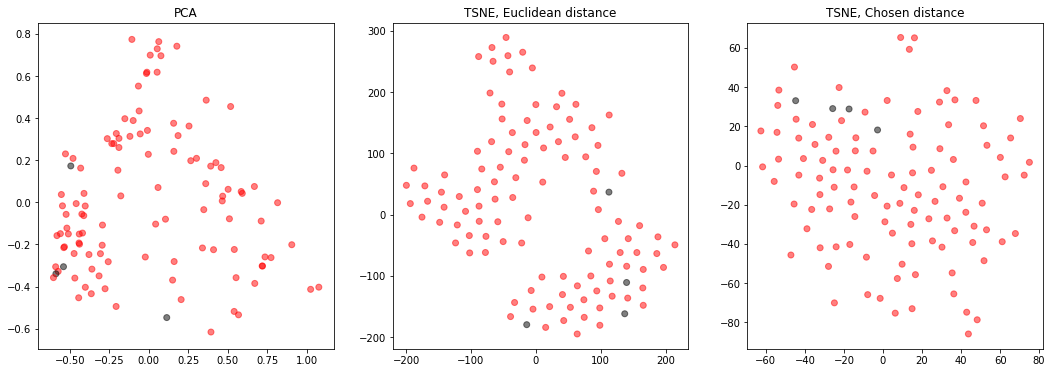

Clustering


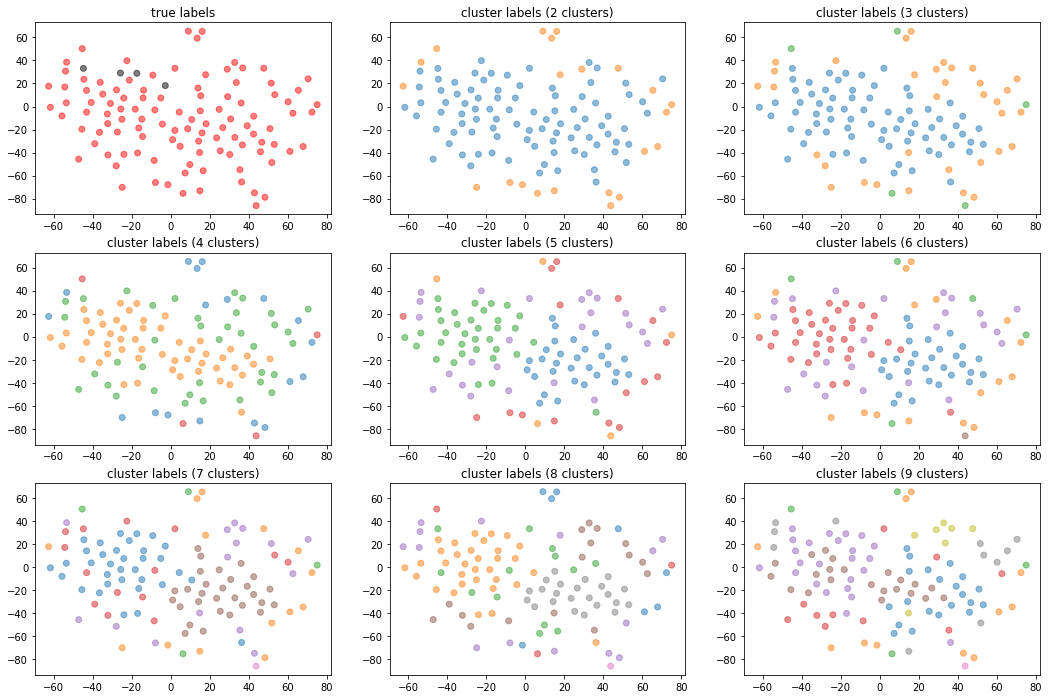

0 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
2,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',0,[],[],0
3,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',0,[],[],0
4,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',0,[],[],0
8,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'ibl',0,[],[],0
9,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'unid',0,[],[],0
12,b'1FGL J0303.5-2406 ',b'BLL ',b'',b'hbl',0,[],[],0
15,b'1FGL J0319.7+1847 ',b'bll ',b'',b'hbl',0,[],[],0
18,b'1FGL J0449.5-4350 ',b'bll ',b'',b'hbl',0,[],[],0
20,b'1FGL J0521.7+2114 ',b'bll ',b'',b'ibl',0,[],[],0
22,b' ',b'PWN ',b'',b'psr',0,[],[],0


1 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
0,b' ',b'bll ',b'',b'hbl',0,[],[],0
1,b' ',b'snr ',b'',b'snr',0,[],[],0
16,b' ',b'bll ',b'',b'hbl',0,[],[],0
19,b'1FGL J0507.9+6738 ',b'bll ',b'',b'hbl',0,[],[],0
21,b' ',b' ',b'',"b'snr,mc'",0,[],[],0
26,b' ',b'bll ',b'',b'hbl',0,[],[],0
30,b'1FGL J0710.6+5911 ',b'bll ',b'1FGL J0710.6+5911',b'hbl',0,[],[],0
42,b'1FGL J1103.7-2329 ',b'bll ',b'',b'hbl',0,[],[],0
48,b'1FGL J1221.3+3008 ',b'bll ',b'',b'hbl',0,[],[],0
55,b' ',b'bcu ',b'',b'hbl',0,[],[],0


2 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
10,b' ',b'bll ',b'',b'hbl',0,[],[],0
13,b' ',b'rdg ',b'',b'hbl',0,[],[],0
38,b'1FGL J1015.1+4927 ',b'bll ',b'',b'hbl',0,[],[],0
54,b' ',b'PWN ',b'',b'pwn',0,[],[],0
80,b'1FGL J1727.9+5010 ',b'bll ',b'',b'hbl',0,[],[],0


3 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
6,b'1FGL J0205.6+6449 ',b'PSR ',b'',b'pwn',0,[],[],0
7,b'1FGL J0221.0+3555 ',b'FSRQ ',b'',b'blazar',0,[],[],0
11,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1,['B0Ve'],"[""b'LS I +61 303'"" ""b'LS I +61 303'""]",1
14,b'1FGL J0319.7+4130 ',b'RDG ',b'',b'fri',0,[],[],0
23,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'psr',0,[],[],0
25,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'pwn',0,[],[],0
31,b'1FGL J0721.9+7120 ',b'BLL ',b'',b'ibl',0,[],[],0
36,b'1FGL J1000.1+6539 ',b'bll ',b'',b'blazar',0,[],[],0
39,b' ',b'PSR ',b'',b'pwn',0,[],[],0
40,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1,['B0Ve'],"[""b'2FGL J1019.0-5856'""]",2


4 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
5,b' ',b'bll ',b'',b'hbl',0,[],[],0
17,b'1FGL J0416.8+0107 ',b'bll ',b'',b'hbl',0,[],[],0
27,b'1FGL J0633.9+1746 ',b'PSR ',b'',"b'psr,pwn'",0,[],[],0
28,b'1FGL J0648.8+1516 ',b'bll ',b'1FGL J0648.8+1516',b'hbl',0,[],[],0
33,b' ',b'PWN ',b'',b'pwn',0,[],[],0
35,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0,['B0Ve'],"[""b'[CHP2004] J095549.8+693934'"" ""b'[MTK2001b]...",2
37,b' ',b'bll ',b'',b'hbl',0,[],[],0
49,b'1FGL J1221.5+2814 ',b'bll ',b'',b'ibl',0,[],[],0
50,b' ',b'bll ',b'',b'hbl',0,[],[],0
56,b'1FGL J1325.6-4300 ',b'RDG ',b'',b'fri',0,[],[],0


5 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
65,b'1FGL J1512.8-0906 ',b'FSRQ ',b'',b'fsrq',0,[],[],0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.268204,0.161988,0.109557,0.214304,0.120705,0.0,0.082663,0.025208,0.011310,0.004394,0.001668
1,0.190556,0.125254,0.048406,0.129858,0.097965,0.0,0.121906,0.056717,0.039046,0.052310,0.137981
2,0.116782,0.138447,0.035316,0.114096,0.061777,0.0,0.148978,0.095635,0.087429,0.081746,0.119792
3,0.040474,0.217391,0.276167,0.132294,0.264785,0.0,0.028460,0.012407,0.008884,0.007719,0.011418
4,0.087597,0.168247,0.189587,0.120130,0.176937,0.0,0.126481,0.045725,0.033811,0.026483,0.025001
5,0.000057,0.000393,0.000838,0.000202,0.000636,0.0,0.000009,0.000187,0.002927,0.059691,0.935061


In [14]:
plt.clf()
metric_function = "mahalanobis"
min_element = np.min(spectra_no_zeros2[new_columns].values[(np.nonzero(spectra_no_zeros2[new_columns].values))])
print(min_element)
noise = pd.DataFrame(data = np.random.randn(spectra_no_zeros2[new_columns].shape[0], spectra_no_zeros2[new_columns].shape[1]), columns = new_columns)
m = spectra_no_zeros2[new_columns] + min_element*noise
spectra_distances = pairwise_distances(m, metric=metric_function)
build_images(spectra_distances, 700, 1500, 400)
print_clusters_structure(spectra_distances, 6)

- ### canberra
$$d(u, v) = \sum_{i} \frac{|u_i - v_i|}{|u_i| + |v_i|}$$

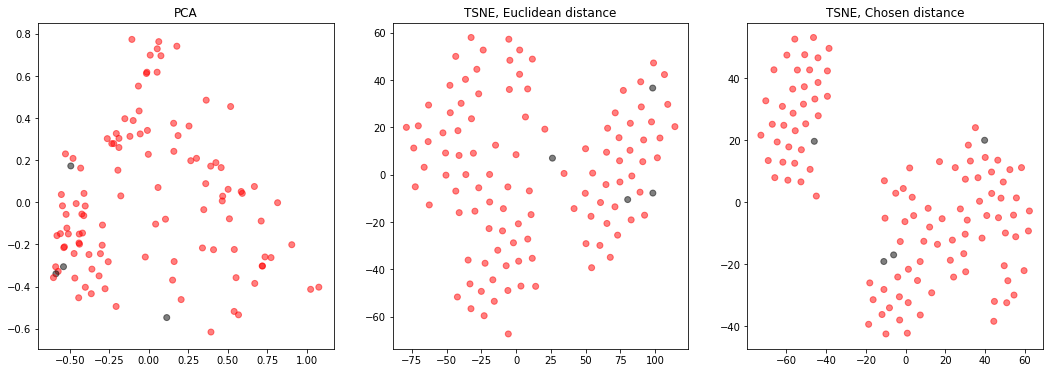

Clustering


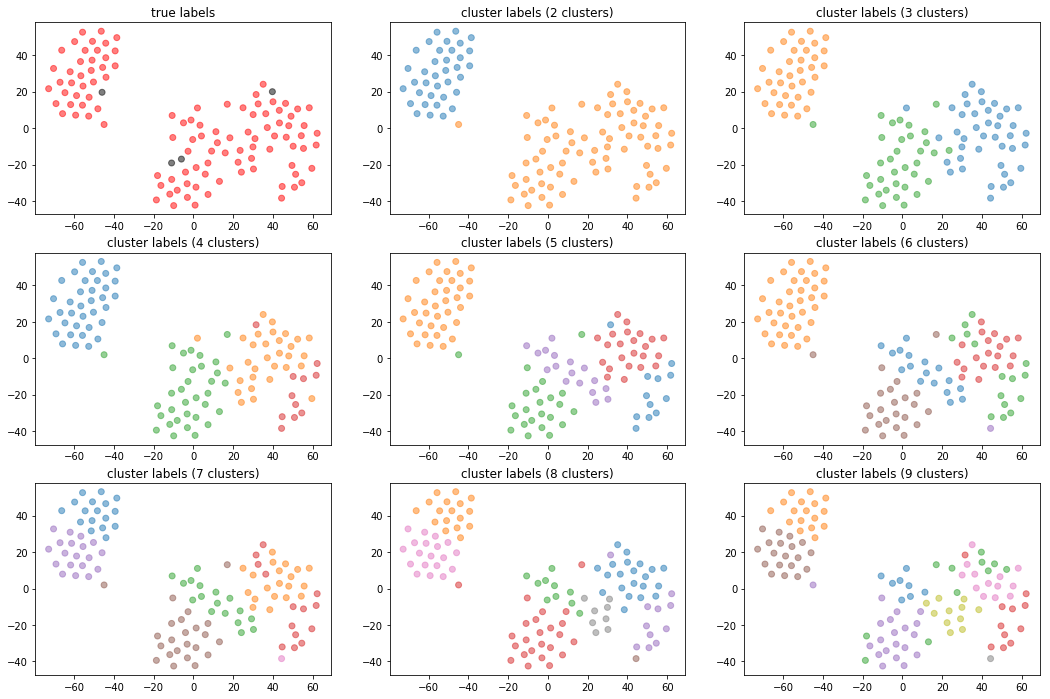

0 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
1,b' ',b'snr ',b'',b'snr',0,[],[],0
16,b' ',b'bll ',b'',b'hbl',0,[],[],0
37,b' ',b'bll ',b'',b'hbl',0,[],[],0
38,b'1FGL J1015.1+4927 ',b'bll ',b'',b'hbl',0,[],[],0
42,b'1FGL J1103.7-2329 ',b'bll ',b'',b'hbl',0,[],[],0
54,b' ',b'PWN ',b'',b'pwn',0,[],[],0
61,b'1FGL J1428.7+4239 ',b'bll ',b'',b'hbl',0,[],[],0
65,b'1FGL J1512.8-0906 ',b'FSRQ ',b'',b'fsrq',0,[],[],0
66,b'1FGL J1513.2-5904 ',b'PSR ',b'',b'pwn',0,[],[],0
67,b'1FGL J1514.7-5917 ',b'PWN ',b'',b'pwn',0,[],[],0


1 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
2,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',0,[],[],0
3,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',0,[],[],0
4,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',0,[],[],0
6,b'1FGL J0205.6+6449 ',b'PSR ',b'',b'pwn',0,[],[],0
7,b'1FGL J0221.0+3555 ',b'FSRQ ',b'',b'blazar',0,[],[],0
9,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'unid',0,[],[],0
13,b' ',b'rdg ',b'',b'hbl',0,[],[],0
14,b'1FGL J0319.7+4130 ',b'RDG ',b'',b'fri',0,[],[],0
19,b'1FGL J0507.9+6738 ',b'bll ',b'',b'hbl',0,[],[],0
22,b' ',b'PWN ',b'',b'psr',0,[],[],0


2 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
11,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1,['B0Ve'],"[""b'LS I +61 303'"" ""b'LS I +61 303'""]",1
25,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'pwn',0,[],[],0
40,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1,['B0Ve'],"[""b'2FGL J1019.0-5856'""]",2
41,b'1FGL J1028.4-5819 ',b'PSR ',b'',b'pwn',0,[],[],0
51,b'1FGL J1224.7+2121 ',b'FSRQ ',b'',b'fsrq',0,[],[],0
53,b'1FGL J1256.2-0547 ',b'FSRQ ',b'',b'fsrq',0,[],[],0
58,b'1FGL J1418.7-6057 ',b'PSR ',b'',b'pwn',0,[],[],0
59,b'1FGL J1418.7-6057 ',b'PSR ',b'',b'pwn',0,[],[],0
68,b'1FGL J1517.8-2423 ',b'bll ',b'',b'lbl',0,[],[],0
73,b' ',b'spp ',b'',b'unid',0,[],[],0


3 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
5,b' ',b'bll ',b'',b'hbl',0,[],[],0
10,b' ',b'bll ',b'',b'hbl',0,[],[],0
21,b' ',b' ',b'',"b'snr,mc'",0,[],[],0
24,b' ',b'PWN ',b'',b'pwn',0,[],[],0
30,b'1FGL J0710.6+5911 ',b'bll ',b'1FGL J0710.6+5911',b'hbl',0,[],[],0
33,b' ',b'PWN ',b'',b'pwn',0,[],[],0
45,b'1FGL J1136.6+7009 ',b'bll ',b'',b'hbl',0,[],[],0
49,b'1FGL J1221.5+2814 ',b'bll ',b'',b'ibl',0,[],[],0
55,b' ',b'bcu ',b'',b'hbl',0,[],[],0
57,b' ',b'PSR ',b'',b'pwn',0,[],[],0


4 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
0,b' ',b'bll ',b'',b'hbl',0,[],[],0
8,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'ibl',0,[],[],0
12,b'1FGL J0303.5-2406 ',b'BLL ',b'',b'hbl',0,[],[],0
15,b'1FGL J0319.7+1847 ',b'bll ',b'',b'hbl',0,[],[],0
17,b'1FGL J0416.8+0107 ',b'bll ',b'',b'hbl',0,[],[],0
18,b'1FGL J0449.5-4350 ',b'bll ',b'',b'hbl',0,[],[],0
20,b'1FGL J0521.7+2114 ',b'bll ',b'',b'ibl',0,[],[],0
28,b'1FGL J0648.8+1516 ',b'bll ',b'1FGL J0648.8+1516',b'hbl',0,[],[],0
31,b'1FGL J0721.9+7120 ',b'BLL ',b'',b'ibl',0,[],[],0
32,b'1FGL J0809.5+5219 ',b'bll ',b'',b'hbl',0,[],[],0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.117345,0.041470,0.056835,0.053345,0.044963,0.0,0.110236,0.063484,0.072430,0.106462,0.333429
1,0.176185,0.226139,0.195301,0.199273,0.203102,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.026789,0.220352,0.266320,0.120476,0.278544,0.0,0.033828,0.015854,0.010957,0.010893,0.015986
3,0.144551,0.112679,0.120443,0.111950,0.111275,0.0,0.187747,0.092573,0.057681,0.036903,0.024198
4,0.201685,0.168698,0.105002,0.196866,0.127778,0.0,0.166301,0.026448,0.006259,0.000824,0.000138


In [15]:
metric_function = "canberra"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances)
print_clusters_structure(spectra_distances, 5)

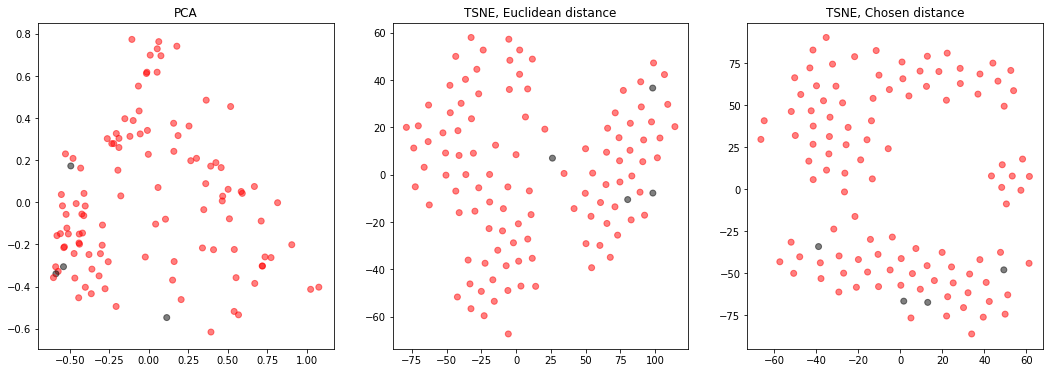

Clustering


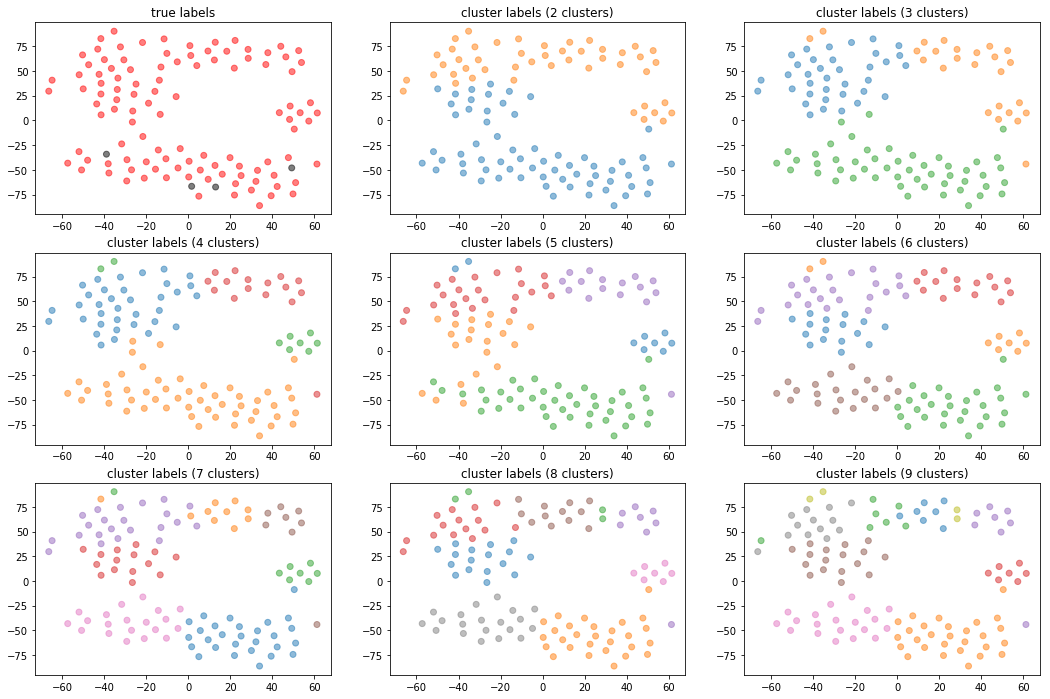

0 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
1,b' ',b'snr ',b'',b'snr',0,[],[],0
16,b' ',b'bll ',b'',b'hbl',0,[],[],0
37,b' ',b'bll ',b'',b'hbl',0,[],[],0
38,b'1FGL J1015.1+4927 ',b'bll ',b'',b'hbl',0,[],[],0
42,b'1FGL J1103.7-2329 ',b'bll ',b'',b'hbl',0,[],[],0
54,b' ',b'PWN ',b'',b'pwn',0,[],[],0
61,b'1FGL J1428.7+4239 ',b'bll ',b'',b'hbl',0,[],[],0
65,b'1FGL J1512.8-0906 ',b'FSRQ ',b'',b'fsrq',0,[],[],0
69,b'1FGL J1555.7+1111 ',b'BLL ',b'',b'hbl',0,[],[],0


1 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
3,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',0,[],[],0
8,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'ibl',0,[],[],0
9,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'unid',0,[],[],0
12,b'1FGL J0303.5-2406 ',b'BLL ',b'',b'hbl',0,[],[],0
18,b'1FGL J0449.5-4350 ',b'bll ',b'',b'hbl',0,[],[],0
20,b'1FGL J0521.7+2114 ',b'bll ',b'',b'ibl',0,[],[],0
31,b'1FGL J0721.9+7120 ',b'BLL ',b'',b'ibl',0,[],[],0
32,b'1FGL J0809.5+5219 ',b'bll ',b'',b'hbl',0,[],[],0
46,b'1FGL J1136.2+6739 ',b'bll ',b'',b'hbl',0,[],[],0
47,b'1FGL J1217.7+3007 ',b'bll ',b'',b'hbl',0,[],[],0


2 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
6,b'1FGL J0205.6+6449 ',b'PSR ',b'',b'pwn',0,[],[],0
7,b'1FGL J0221.0+3555 ',b'FSRQ ',b'',b'blazar',0,[],[],0
11,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1,['B0Ve'],"[""b'LS I +61 303'"" ""b'LS I +61 303'""]",1
14,b'1FGL J0319.7+4130 ',b'RDG ',b'',b'fri',0,[],[],0
23,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'psr',0,[],[],0
25,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'pwn',0,[],[],0
27,b'1FGL J0633.9+1746 ',b'PSR ',b'',"b'psr,pwn'",0,[],[],0
33,b' ',b'PWN ',b'',b'pwn',0,[],[],0
35,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0,['B0Ve'],"[""b'[CHP2004] J095549.8+693934'"" ""b'[MTK2001b]...",2
36,b'1FGL J1000.1+6539 ',b'bll ',b'',b'blazar',0,[],[],0


3 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
2,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',0,[],[],0
4,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',0,[],[],0
13,b' ',b'rdg ',b'',b'hbl',0,[],[],0
15,b'1FGL J0319.7+1847 ',b'bll ',b'',b'hbl',0,[],[],0
19,b'1FGL J0507.9+6738 ',b'bll ',b'',b'hbl',0,[],[],0
21,b' ',b' ',b'',"b'snr,mc'",0,[],[],0
22,b' ',b'PWN ',b'',b'psr',0,[],[],0
26,b' ',b'bll ',b'',b'hbl',0,[],[],0
28,b'1FGL J0648.8+1516 ',b'bll ',b'1FGL J0648.8+1516',b'hbl',0,[],[],0
29,b'1FGL J0650.7+2503 ',b'bll ',b'',b'hbl',0,[],[],0


4 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
0,b' ',b'bll ',b'',b'hbl',0,[],[],0
5,b' ',b'bll ',b'',b'hbl',0,[],[],0
10,b' ',b'bll ',b'',b'hbl',0,[],[],0
17,b'1FGL J0416.8+0107 ',b'bll ',b'',b'hbl',0,[],[],0
24,b' ',b'PWN ',b'',b'pwn',0,[],[],0
30,b'1FGL J0710.6+5911 ',b'bll ',b'1FGL J0710.6+5911',b'hbl',0,[],[],0
45,b'1FGL J1136.6+7009 ',b'bll ',b'',b'hbl',0,[],[],0
49,b'1FGL J1221.5+2814 ',b'bll ',b'',b'ibl',0,[],[],0
57,b' ',b'PSR ',b'',b'pwn',0,[],[],0
63,b'1FGL J1443.8+2457 ',b'fsrq ',b'3FGL J1443.9+2502',b'fsrq',0,[],[],0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.124318,0.044078,0.024232,0.053977,0.041981,0.0,0.059290,0.039178,0.059586,0.118697,0.434665
1,0.177395,0.219001,0.152264,0.219040,0.178057,0.0,0.039963,0.007746,0.003079,0.001896,0.001559
2,0.031687,0.218570,0.285809,0.116444,0.271620,0.0,0.025728,0.015705,0.011516,0.010555,0.012367
3,0.312970,0.160107,0.054071,0.222191,0.090456,0.0,0.080815,0.038270,0.024411,0.012239,0.004470
4,0.109183,0.081755,0.108138,0.088740,0.086487,0.0,0.308378,0.103136,0.056762,0.034874,0.022547


In [16]:
metric_function = "correlation"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances)
print_clusters_structure(spectra_distances, 5)

- ### cityblock
$$ d(u, v) = \sum_{i} |u_i - v_i|$$

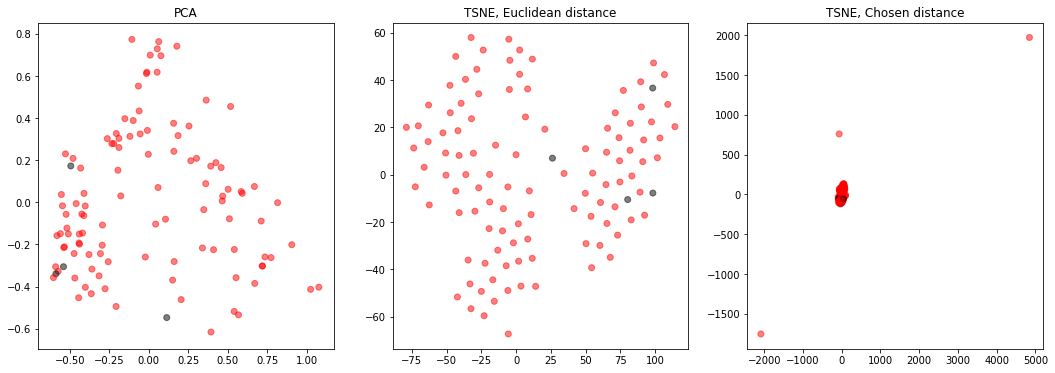

Clustering


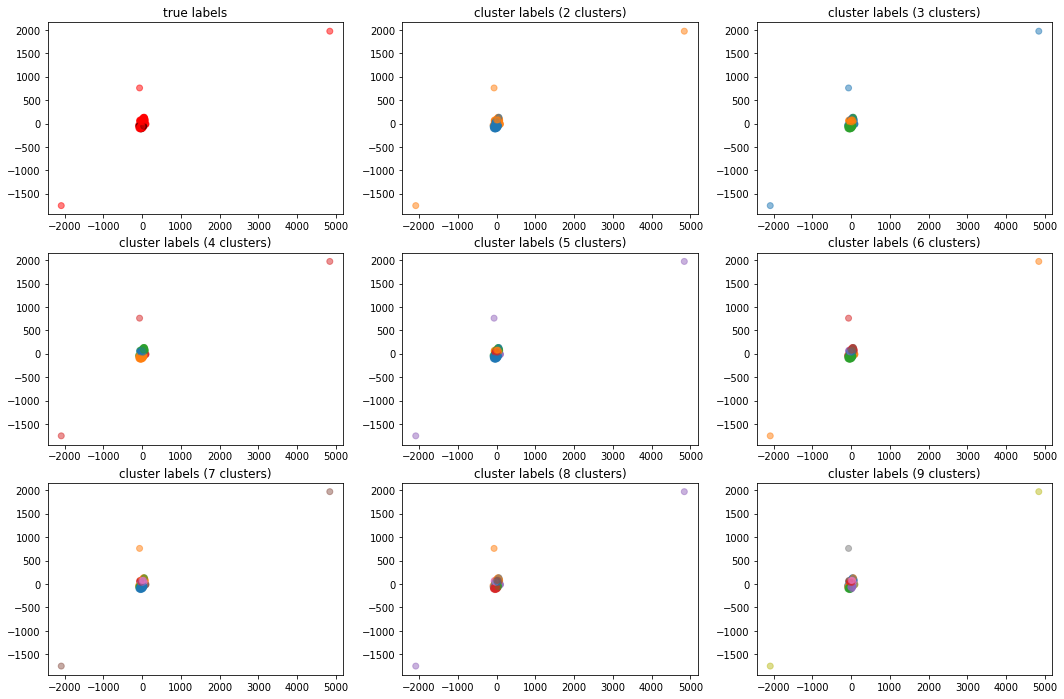

0 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
6,b'1FGL J0205.6+6449 ',b'PSR ',b'',b'pwn',0,[],[],0
7,b'1FGL J0221.0+3555 ',b'FSRQ ',b'',b'blazar',0,[],[],0
11,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1,['B0Ve'],"[""b'LS I +61 303'"" ""b'LS I +61 303'""]",1
14,b'1FGL J0319.7+4130 ',b'RDG ',b'',b'fri',0,[],[],0
23,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'psr',0,[],[],0
25,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'pwn',0,[],[],0
27,b'1FGL J0633.9+1746 ',b'PSR ',b'',"b'psr,pwn'",0,[],[],0
33,b' ',b'PWN ',b'',b'pwn',0,[],[],0
35,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0,['B0Ve'],"[""b'[CHP2004] J095549.8+693934'"" ""b'[MTK2001b]...",2
36,b'1FGL J1000.1+6539 ',b'bll ',b'',b'blazar',0,[],[],0


1 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
0,b' ',b'bll ',b'',b'hbl',0,[],[],0
4,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',0,[],[],0
5,b' ',b'bll ',b'',b'hbl',0,[],[],0
13,b' ',b'rdg ',b'',b'hbl',0,[],[],0
15,b'1FGL J0319.7+1847 ',b'bll ',b'',b'hbl',0,[],[],0
17,b'1FGL J0416.8+0107 ',b'bll ',b'',b'hbl',0,[],[],0
19,b'1FGL J0507.9+6738 ',b'bll ',b'',b'hbl',0,[],[],0
21,b' ',b' ',b'',"b'snr,mc'",0,[],[],0
22,b' ',b'PWN ',b'',b'psr',0,[],[],0
24,b' ',b'PWN ',b'',b'pwn',0,[],[],0


2 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
10,b' ',b'bll ',b'',b'hbl',0,[],[],0
30,b'1FGL J0710.6+5911 ',b'bll ',b'1FGL J0710.6+5911',b'hbl',0,[],[],0
37,b' ',b'bll ',b'',b'hbl',0,[],[],0
49,b'1FGL J1221.5+2814 ',b'bll ',b'',b'ibl',0,[],[],0
54,b' ',b'PWN ',b'',b'pwn',0,[],[],0
57,b' ',b'PSR ',b'',b'pwn',0,[],[],0
61,b'1FGL J1428.7+4239 ',b'bll ',b'',b'hbl',0,[],[],0
63,b'1FGL J1443.8+2457 ',b'fsrq ',b'3FGL J1443.9+2502',b'fsrq',0,[],[],0
66,b'1FGL J1513.2-5904 ',b'PSR ',b'',b'pwn',0,[],[],0
67,b'1FGL J1514.7-5917 ',b'PWN ',b'',b'pwn',0,[],[],0


3 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
2,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',0,[],[],0
3,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',0,[],[],0
8,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'ibl',0,[],[],0
9,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'unid',0,[],[],0
12,b'1FGL J0303.5-2406 ',b'BLL ',b'',b'hbl',0,[],[],0
18,b'1FGL J0449.5-4350 ',b'bll ',b'',b'hbl',0,[],[],0
20,b'1FGL J0521.7+2114 ',b'bll ',b'',b'ibl',0,[],[],0
31,b'1FGL J0721.9+7120 ',b'BLL ',b'',b'ibl',0,[],[],0
32,b'1FGL J0809.5+5219 ',b'bll ',b'',b'hbl',0,[],[],0
46,b'1FGL J1136.2+6739 ',b'bll ',b'',b'hbl',0,[],[],0


4 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
1,b' ',b'snr ',b'',b'snr',0,[],[],0
16,b' ',b'bll ',b'',b'hbl',0,[],[],0
38,b'1FGL J1015.1+4927 ',b'bll ',b'',b'hbl',0,[],[],0
42,b'1FGL J1103.7-2329 ',b'bll ',b'',b'hbl',0,[],[],0
65,b'1FGL J1512.8-0906 ',b'FSRQ ',b'',b'fsrq',0,[],[],0
69,b'1FGL J1555.7+1111 ',b'BLL ',b'',b'hbl',0,[],[],0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.032621,0.229635,0.265611,0.126630,0.268520,0.0,0.031157,0.014744,0.010457,0.009494,0.011131
1,0.287506,0.150116,0.046333,0.204468,0.083718,0.0,0.133845,0.049328,0.027002,0.012703,0.004983
2,0.116001,0.058347,0.115337,0.066394,0.076295,0.0,0.242962,0.112972,0.087936,0.068882,0.054873
3,0.225068,0.182731,0.159599,0.216565,0.151794,0.0,0.043838,0.010131,0.005176,0.003379,0.001718
4,0.065013,0.034558,0.010000,0.041459,0.041369,0.0,0.066737,0.017971,0.023507,0.110672,0.588713


In [17]:
metric_function = "cityblock"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances)
print_clusters_structure(spectra_distances, 5)

- ### braycurtis 
$$d(u, v) = \frac{\sum_{i} |u_i - v_i|}{\sum_{i}|u_i + v_i|}$$

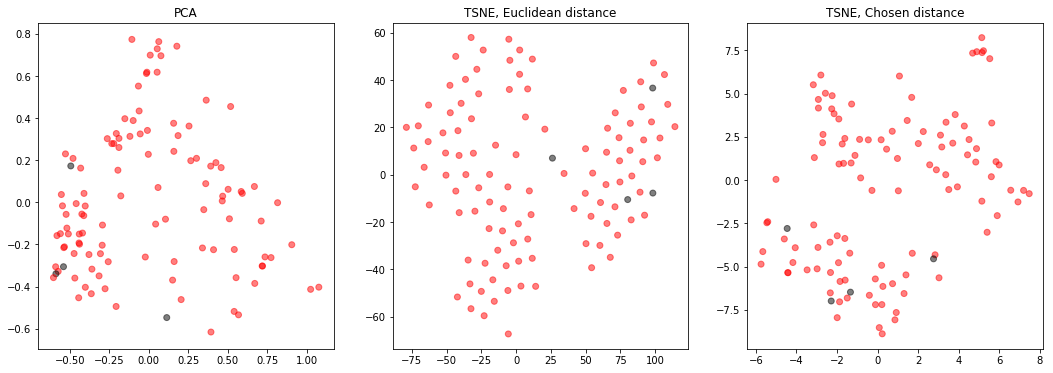

Clustering


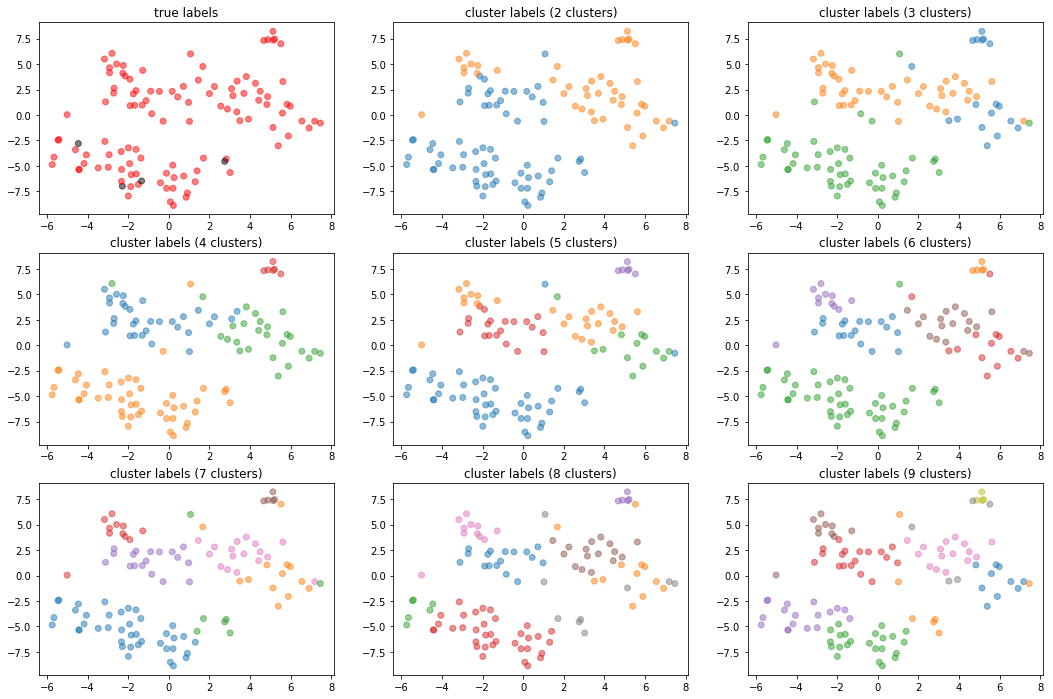

0 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
6,b'1FGL J0205.6+6449 ',b'PSR ',b'',b'pwn',0,[],[],0
7,b'1FGL J0221.0+3555 ',b'FSRQ ',b'',b'blazar',0,[],[],0
11,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1,['B0Ve'],"[""b'LS I +61 303'"" ""b'LS I +61 303'""]",1
14,b'1FGL J0319.7+4130 ',b'RDG ',b'',b'fri',0,[],[],0
23,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'psr',0,[],[],0
25,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'pwn',0,[],[],0
27,b'1FGL J0633.9+1746 ',b'PSR ',b'',"b'psr,pwn'",0,[],[],0
35,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0,['B0Ve'],"[""b'[CHP2004] J095549.8+693934'"" ""b'[MTK2001b]...",2
36,b'1FGL J1000.1+6539 ',b'bll ',b'',b'blazar',0,[],[],0
39,b' ',b'PSR ',b'',b'pwn',0,[],[],0


1 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
1,b' ',b'snr ',b'',b'snr',0,[],[],0
10,b' ',b'bll ',b'',b'hbl',0,[],[],0
30,b'1FGL J0710.6+5911 ',b'bll ',b'1FGL J0710.6+5911',b'hbl',0,[],[],0
37,b' ',b'bll ',b'',b'hbl',0,[],[],0
54,b' ',b'PWN ',b'',b'pwn',0,[],[],0
57,b' ',b'PSR ',b'',b'pwn',0,[],[],0
61,b'1FGL J1428.7+4239 ',b'bll ',b'',b'hbl',0,[],[],0
63,b'1FGL J1443.8+2457 ',b'fsrq ',b'3FGL J1443.9+2502',b'fsrq',0,[],[],0
66,b'1FGL J1513.2-5904 ',b'PSR ',b'',b'pwn',0,[],[],0
67,b'1FGL J1514.7-5917 ',b'PWN ',b'',b'pwn',0,[],[],0


2 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
33,b' ',b'PWN ',b'',b'pwn',0,[],[],0
55,b' ',b'bcu ',b'',b'hbl',0,[],[],0
68,b'1FGL J1517.8-2423 ',b'bll ',b'',b'lbl',0,[],[],0
70,b'1FGL J1617.5-5105c',b'PWN ',b'',b'pwn',0,[],[],0
82,b' ',b'spp ',b'',"b'unid,snr,mc'",0,[],[],0
90,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1,['B0Ve'],"[""b'V* V479 Sct'""]",1
105,b'1FGL J2202.8+4216 ',b'BLL ',b'',b'lbl',0,[],[],0


3 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
2,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',0,[],[],0
4,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',0,[],[],0
13,b' ',b'rdg ',b'',b'hbl',0,[],[],0
19,b'1FGL J0507.9+6738 ',b'bll ',b'',b'hbl',0,[],[],0
21,b' ',b' ',b'',"b'snr,mc'",0,[],[],0
22,b' ',b'PWN ',b'',b'psr',0,[],[],0
26,b' ',b'bll ',b'',b'hbl',0,[],[],0
29,b'1FGL J0650.7+2503 ',b'bll ',b'',b'hbl',0,[],[],0
34,b'1FGL J0847.2+1134 ',b'bll ',"b'1FGL J0847.2+113,2FGL J0847.2+1134,3FGL J084...",b'hbl',0,[],[],0
48,b'1FGL J1221.3+3008 ',b'bll ',b'',b'hbl',0,[],[],0


4 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
3,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',0,[],[],0
8,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'ibl',0,[],[],0
9,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'unid',0,[],[],0
12,b'1FGL J0303.5-2406 ',b'BLL ',b'',b'hbl',0,[],[],0
18,b'1FGL J0449.5-4350 ',b'bll ',b'',b'hbl',0,[],[],0
20,b'1FGL J0521.7+2114 ',b'bll ',b'',b'ibl',0,[],[],0
31,b'1FGL J0721.9+7120 ',b'BLL ',b'',b'ibl',0,[],[],0
32,b'1FGL J0809.5+5219 ',b'bll ',b'',b'hbl',0,[],[],0
46,b'1FGL J1136.2+6739 ',b'bll ',b'',b'hbl',0,[],[],0
47,b'1FGL J1217.7+3007 ',b'bll ',b'',b'hbl',0,[],[],0


5 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
16,b' ',b'bll ',b'',b'hbl',0,[],[],0
38,b'1FGL J1015.1+4927 ',b'bll ',b'',b'hbl',0,[],[],0
42,b'1FGL J1103.7-2329 ',b'bll ',b'',b'hbl',0,[],[],0
65,b'1FGL J1512.8-0906 ',b'FSRQ ',b'',b'fsrq',0,[],[],0
69,b'1FGL J1555.7+1111 ',b'BLL ',b'',b'hbl',0,[],[],0


6 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
0,b' ',b'bll ',b'',b'hbl',0,[],[],0
5,b' ',b'bll ',b'',b'hbl',0,[],[],0
15,b'1FGL J0319.7+1847 ',b'bll ',b'',b'hbl',0,[],[],0
17,b'1FGL J0416.8+0107 ',b'bll ',b'',b'hbl',0,[],[],0
24,b' ',b'PWN ',b'',b'pwn',0,[],[],0
28,b'1FGL J0648.8+1516 ',b'bll ',b'1FGL J0648.8+1516',b'hbl',0,[],[],0
43,b'1FGL J1104.4+3812 ',b'BLL ',b'',b'hbl',0,[],[],0
45,b'1FGL J1136.6+7009 ',b'bll ',b'',b'hbl',0,[],[],0
49,b'1FGL J1221.5+2814 ',b'bll ',b'',b'ibl',0,[],[],0
62,b'1FGL J1442.8+1158 ',b'bll ',b'',b'hbl',0,[],[],0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.031369,0.245792,0.264957,0.136998,0.284305,0.0,0.015938,0.007898,0.005544,0.004767,0.002431
1,0.117629,0.055672,0.106994,0.062007,0.078629,0.0,0.219799,0.110074,0.086895,0.072973,0.089327
2,0.039772,0.137304,0.269351,0.067386,0.178319,0.0,0.118120,0.053861,0.038530,0.036509,0.060847
3,0.407458,0.176917,0.054981,0.256366,0.091373,0.0,0.002740,0.003302,0.003914,0.002056,0.000893
4,0.211400,0.181789,0.167079,0.211937,0.156413,0.0,0.048709,0.011257,0.005751,0.003755,0.001908
5,0.064192,0.026835,0.011319,0.042086,0.020520,0.0,0.053270,0.017480,0.026918,0.120931,0.616450
6,0.202924,0.135129,0.049998,0.170792,0.083738,0.0,0.220656,0.073823,0.038351,0.017715,0.006875


In [18]:
metric_function = "braycurtis"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances)
print_clusters_structure(spectra_distances, 7)

- ### corellation 
$$d(u, v) = 1 -  \frac{(u - \overline{u}) \cdot (v - \overline{v})}{||(u - \overline{u})||_{2} \cdot  ||(v - \overline{v})||_{2}}$$

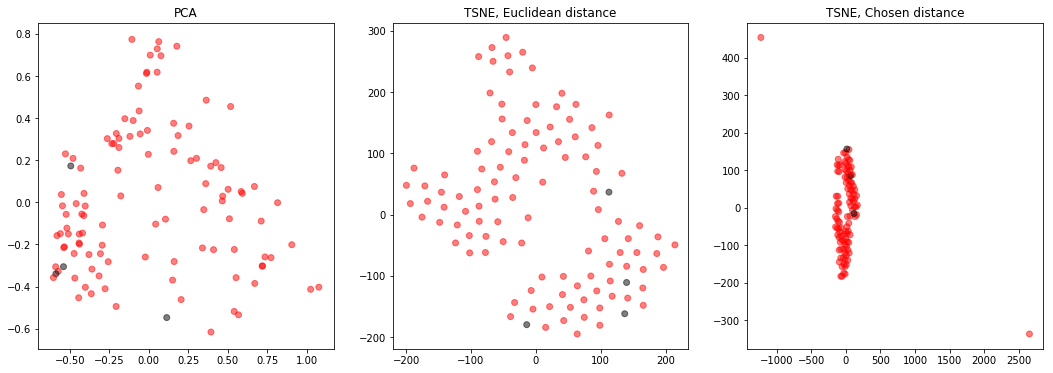

Clustering


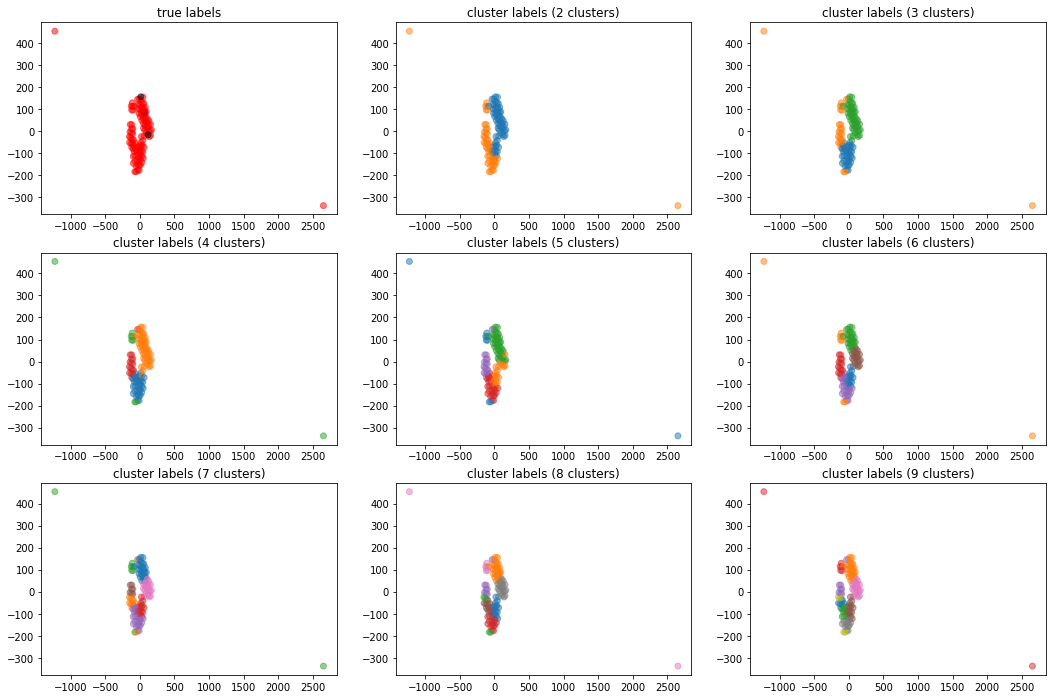

0 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
3,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',0,[],[],0
8,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'ibl',0,[],[],0
9,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'unid',0,[],[],0
12,b'1FGL J0303.5-2406 ',b'BLL ',b'',b'hbl',0,[],[],0
18,b'1FGL J0449.5-4350 ',b'bll ',b'',b'hbl',0,[],[],0
20,b'1FGL J0521.7+2114 ',b'bll ',b'',b'ibl',0,[],[],0
32,b'1FGL J0809.5+5219 ',b'bll ',b'',b'hbl',0,[],[],0
46,b'1FGL J1136.2+6739 ',b'bll ',b'',b'hbl',0,[],[],0
47,b'1FGL J1217.7+3007 ',b'bll ',b'',b'hbl',0,[],[],0
50,b' ',b'bll ',b'',b'hbl',0,[],[],0


1 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
6,b'1FGL J0205.6+6449 ',b'PSR ',b'',b'pwn',0,[],[],0
7,b'1FGL J0221.0+3555 ',b'FSRQ ',b'',b'blazar',0,[],[],0
11,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1,['B0Ve'],"[""b'LS I +61 303'"" ""b'LS I +61 303'""]",1
23,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'psr',0,[],[],0
25,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'pwn',0,[],[],0
33,b' ',b'PWN ',b'',b'pwn',0,[],[],0
36,b'1FGL J1000.1+6539 ',b'bll ',b'',b'blazar',0,[],[],0
39,b' ',b'PSR ',b'',b'pwn',0,[],[],0
40,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1,['B0Ve'],"[""b'2FGL J1019.0-5856'""]",2
44,b'1FGL J1119.4-6127c',b'PSR ',b'',b'pwn',0,[],[],0


2 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
54,b' ',b'PWN ',b'',b'pwn',0,[],[],0
61,b'1FGL J1428.7+4239 ',b'bll ',b'',b'hbl',0,[],[],0
67,b'1FGL J1514.7-5917 ',b'PWN ',b'',b'pwn',0,[],[],0
75,b'1FGL J1711.7-3944c',b'SNR ',b'',b'snr',0,[],[],0


3 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
2,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',0,[],[],0
4,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',0,[],[],0
13,b' ',b'rdg ',b'',b'hbl',0,[],[],0
19,b'1FGL J0507.9+6738 ',b'bll ',b'',b'hbl',0,[],[],0
21,b' ',b' ',b'',"b'snr,mc'",0,[],[],0
22,b' ',b'PWN ',b'',b'psr',0,[],[],0
26,b' ',b'bll ',b'',b'hbl',0,[],[],0
29,b'1FGL J0650.7+2503 ',b'bll ',b'',b'hbl',0,[],[],0
34,b'1FGL J0847.2+1134 ',b'bll ',"b'1FGL J0847.2+113,2FGL J0847.2+1134,3FGL J084...",b'hbl',0,[],[],0
48,b'1FGL J1221.3+3008 ',b'bll ',b'',b'hbl',0,[],[],0


4 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
10,b' ',b'bll ',b'',b'hbl',0,[],[],0
49,b'1FGL J1221.5+2814 ',b'bll ',b'',b'ibl',0,[],[],0
57,b' ',b'PSR ',b'',b'pwn',0,[],[],0
63,b'1FGL J1443.8+2457 ',b'fsrq ',b'3FGL J1443.9+2502',b'fsrq',0,[],[],0
66,b'1FGL J1513.2-5904 ',b'PSR ',b'',b'pwn',0,[],[],0
71,b'1FGL J1626.0-4917c',b' ',b'',b'unid',0,[],[],0
80,b'1FGL J1727.9+5010 ',b'bll ',b'',b'hbl',0,[],[],0
105,b'1FGL J2202.8+4216 ',b'BLL ',b'',b'lbl',0,[],[],0


5 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
0,b' ',b'bll ',b'',b'hbl',0,[],[],0
5,b' ',b'bll ',b'',b'hbl',0,[],[],0
15,b'1FGL J0319.7+1847 ',b'bll ',b'',b'hbl',0,[],[],0
17,b'1FGL J0416.8+0107 ',b'bll ',b'',b'hbl',0,[],[],0
24,b' ',b'PWN ',b'',b'pwn',0,[],[],0
28,b'1FGL J0648.8+1516 ',b'bll ',b'1FGL J0648.8+1516',b'hbl',0,[],[],0
30,b'1FGL J0710.6+5911 ',b'bll ',b'1FGL J0710.6+5911',b'hbl',0,[],[],0
43,b'1FGL J1104.4+3812 ',b'BLL ',b'',b'hbl',0,[],[],0
45,b'1FGL J1136.6+7009 ',b'bll ',b'',b'hbl',0,[],[],0
72,b'1FGL J1640.8-4634c',b'spp ',b'',b'pwn',0,[],[],0


6 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
1,b' ',b'snr ',b'',b'snr',0,[],[],0
16,b' ',b'bll ',b'',b'hbl',0,[],[],0
37,b' ',b'bll ',b'',b'hbl',0,[],[],0
38,b'1FGL J1015.1+4927 ',b'bll ',b'',b'hbl',0,[],[],0
42,b'1FGL J1103.7-2329 ',b'bll ',b'',b'hbl',0,[],[],0
65,b'1FGL J1512.8-0906 ',b'FSRQ ',b'',b'fsrq',0,[],[],0
69,b'1FGL J1555.7+1111 ',b'BLL ',b'',b'hbl',0,[],[],0


7 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked,s_class,s_MAIN_ID,s_simbad
14,b'1FGL J0319.7+4130 ',b'RDG ',b'',b'fri',0,[],[],0
27,b'1FGL J0633.9+1746 ',b'PSR ',b'',"b'psr,pwn'",0,[],[],0
31,b'1FGL J0721.9+7120 ',b'BLL ',b'',b'ibl',0,[],[],0
35,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0,['B0Ve'],"[""b'[CHP2004] J095549.8+693934'"" ""b'[MTK2001b]...",2
41,b'1FGL J1028.4-5819 ',b'PSR ',b'',b'pwn',0,[],[],0
52,b'1FGL J1230.8+1223 ',b'rdg ',b'',b'fri',0,[],[],0
58,b'1FGL J1418.7-6057 ',b'PSR ',b'',b'pwn',0,[],[],0
59,b'1FGL J1418.7-6057 ',b'PSR ',b'',b'pwn',0,[],[],0
78,b'1FGL J1718.2-3825 ',b'PSR ',b'',b'pwn',0,[],[],0
83,b' ',b' ',b'',b'unid',0,['Be' 'B' 'B' 'O'],"[""b'SSTGC 519103'"" ""b'SSTGC 519103'"" ""b'GCIRS ...",1


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.226192,0.175858,0.169025,0.216651,0.147460,0.0,0.044091,0.009864,0.005550,0.003592,0.001717
1,0.029851,0.181706,0.339503,0.095791,0.257868,0.0,0.031105,0.019752,0.014100,0.012550,0.017773
2,0.197207,0.056389,0.009423,0.064177,0.051054,0.0,0.159524,0.138238,0.157594,0.119134,0.047262
3,0.355002,0.172150,0.050175,0.242502,0.089944,0.0,0.030301,0.024907,0.019475,0.011571,0.003973
4,0.038846,0.068008,0.179501,0.060515,0.111834,0.0,0.325675,0.099937,0.055089,0.034330,0.026266
5,0.214479,0.126181,0.041766,0.155031,0.078538,0.0,0.249066,0.079215,0.032892,0.014175,0.008657
6,0.086380,0.036567,0.029970,0.052930,0.036341,0.0,0.067781,0.017385,0.024319,0.107731,0.540596
7,0.041806,0.298343,0.153830,0.176602,0.280866,0.0,0.023221,0.009310,0.006848,0.006474,0.002702


In [19]:
metric_function = "correlation"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances, 700, 1500, 400)
print_clusters_structure(spectra_distances, 8)